# Machine Learning & Naive Bayes
In this project we are to analysing divar advertisement's using naive bayse  
first importing pandas and parsivar (for normalizing)  
and read train and test 

In [3]:
import pandas
import parsivar
import matplotlib.pyplot as plt

train = pandas.read_csv("Data/divar_train.csv")
test = pandas.read_csv("Data/divar_test.csv")


COEFFICIENT = 10000
STOP_WORDS = ['.','و','،','یا','با', 'به', 'در','از', 'هم']


The `CountingProbDist` class is the base class for this problem 

In [4]:
class CountingProbDist:

    def __init__(self, train_df, test_df):
        
        self.train_df = train_df
        self.test_df = test_df
        test_df['guess'] = ''
        self._normalize(self.train_df)
        self._normalize(self.test_df)
        self.labels = list(set(train_df['categories'].tolist()))
        self.dictionary = {lable : dict() for lable in self.labels}
        self.total_words = {lable: 0 for lable in self.labels}

    def _normalize(self, df):
        my_normalizer = parsivar.Normalizer()
        df['target'] = df['title'] + ' ' + df['description'] 
        for i, value in enumerate(df['target']):
            df['target'][i] = my_normalizer.normalize(value)

    def _add(self, word, category):
        self.total_words[category] += 1
        if word not in self.dictionary[category].keys():
            self.dictionary[category][word] = 0
        
        self.dictionary[category][word] += 1


    def train(self):
        my_stemmer = parsivar.FindStems()
        for i, dscr in enumerate(self.train_df['target']):
            for word in dscr.split(' '):
                if word not in STOP_WORDS:
                    self._add(my_stemmer.convert_to_stem(word).split('&')[0], self.train_df['categories'][i])
                    


    def most_rep(self, lable: str, number: int):
        return dict(sorted(list(self.dictionary[lable].items()), key=lambda x: x[1])[-1-number:-1])

    def _prob_word(self, word, lable):
        if word in self.dictionary[lable].keys():
            return COEFFICIENT * (self.dictionary[lable][word] / self.total_words[lable])
        else:
            return 0

    def _prob_word_smoothing(self, word, label):
        denominator = 1 + self.total_words[label] + len(self.dictionary[label])
        if word in self.dictionary[label].keys():
            return COEFFICIENT * (1 + self.dictionary[label][word]) / denominator
        else:
            return COEFFICIENT / denominator

    def naive_bayes_classification(self) -> dict:
        my_stemmer = parsivar.FindStems()
        correct_detected = {lable : 0 for lable in self.labels}
        wrong_detected = {lable : 0 for lable in self.labels}
        for i, dscr in enumerate(self.test_df['target']):
            all_prob = {lable: 1 for lable in self.labels}

            for word in dscr.split(' '):
                stemmed_word = my_stemmer.convert_to_stem(word)
                for lable in self.labels:
                    all_prob[lable] *= self._prob_word(stemmed_word, lable)

            guessed = max(all_prob, key=all_prob.get)
            self.test_df['guess'][i] = guessed
            if guessed == self.test_df['categories'][i]:
                correct_detected[guessed] += 1
            else:
                wrong_detected[guessed] += 1
        return (correct_detected, wrong_detected)
    
    def naive_bayes_classification_smoothing(self) -> dict:
        my_stemmer = parsivar.FindStems()
        correct_detected = {lable : 0 for lable in self.labels}
        wrong_detected = {lable : 0 for lable in self.labels}
        for i, dscr in enumerate(self.test_df['target']):
            all_prob = {lable: 1 for lable in self.labels}

            for word in dscr.split(' '):
                stemmed_word = my_stemmer.convert_to_stem(word)
                for lable in self.labels:
                    all_prob[lable] *= self._prob_word_smoothing(stemmed_word, lable)

            guessed = max(all_prob, key=all_prob.get)
            self.test_df['guess'][i] = guessed
            if guessed == self.test_df['categories'][i]:
                correct_detected[guessed] += 1
            else:
                wrong_detected[guessed] += 1
        return (correct_detected, wrong_detected)


    def accuracy(self, correct_detected: dict):
        return (sum(correct_detected.values())/self.test_df.shape[0])

    def recall(self, correct_detected: dict, lable: str):
        return (correct_detected[lable]/ self.test_df[self.test_df['categories'] == lable].shape[0])
    
    def precision(self, correct_detected: dict, wrong_detected: dict, lable: str):
        return (correct_detected[lable]/(correct_detected[lable] + wrong_detected[lable]))

    def f1(self, precision, recall):
        return 2 * ((precision * recall)/(precision + recall))

    def macro_f1(self, f1_scores: dict):
        return sum(f1_scores.values()) / len(f1_scores)

    def micro_f1(self, correct_detected: dict):
        return self.accuracy(correct_detected)
    
    def weighted_f1(self, f1_scores: dict):
        total_sum = 0
        for lable in self.labels:
            total_sum += f1_scores[lable] * self.test_df[self.test_df['categories'] == lable].shape[0]
        return total_sum / self.test_df.shape[0]

## Preprocessing the data
The `_normalize` function is used to normalizing data using `parsivar.Normalize()` class  
other normalizing has been done in `naive_bayse_classification` function using `parsivar.FindStem()` class

1. Stemming just removes or stems the last few characters of a word, often leading to incorrect meaning and spelling.
2. Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma.

For example if you lemmatize word **'Caring'**, it would return **'Care'**. If you stem, it would return **'Car'** and this is erroneous.

In [5]:
divar = CountingProbDist(train, test)
divar.train()

## Problem Process

* Posterior Probability: is the probability of a category givne a sentance
* Likelihood: is the probability of a sentence given the category
* Class Prior Probability: is the probability of occuring a category (in this problem all are equal)
* Predictor Prior Probability: is the probability of occuring a sentance

We assumed that all word in a sentance are indepandant from each other, so by naive bays law we can calculate:  
P(c|X) = p(x<sub>1</sub>|c) * p(x<sub>2</sub>|c) * ... * p(x<sub>n</sub>|c) * p(c)

## Bigrams
We are using bag of words model in this problem but it has some problem cause we don't consider context of sentances. for solving this problem we can instead use two continious word. It's because some words have multiple meanings like:  
> I **left** my wallet in the car.

> My car is on the **left** side of the street.

In this example we can notice the different using bigram but it's not always the case some time we need to use n-grams

## Additive Smoothing
As is obvious in naive bays formular if a word is not in a category the probability (for example p(x<sub>k</sub>|c)) becomes zero. (even all other words have a high probability!)  
so in addition to `_prob_word` function there is another function `_prob_word_smothing` that uses smoothing which is described bellow:  
We add a hypothetical word to the words set, for all the word that is not in the set so the probability of any word is calculated with $p(w|c) = (count(w, c) + 1) \div (count(c) + |V| + 1) $

## Verification
First we define `bar_plot` function that uses `matplotlib.pyplot` to draw a bar plot it's argument is dictionary of all word of a category and the title (category name) that we want to use

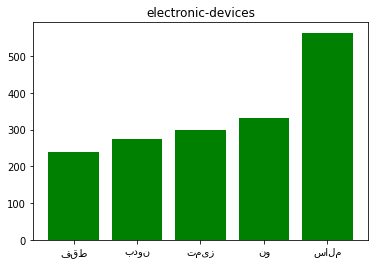

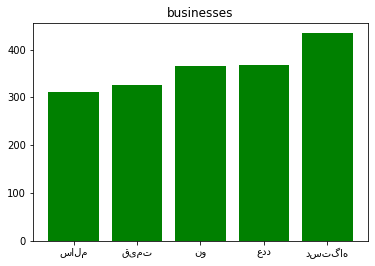

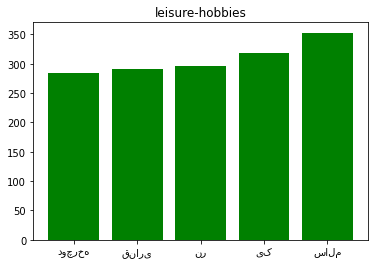

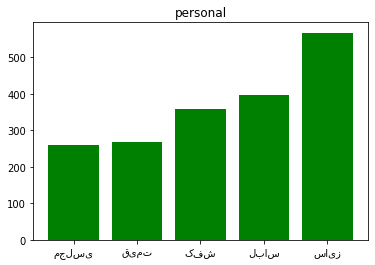

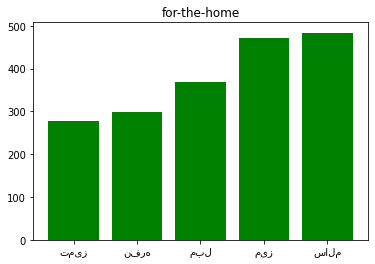

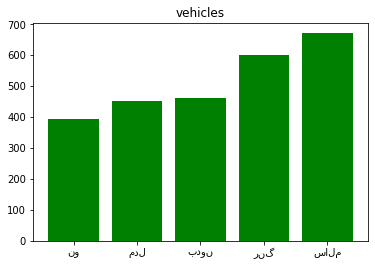

In [6]:
def bar_plot(dictionary: dict, title: str):
    fig = plt.figure()
    plt.bar(dictionary.keys(), dictionary.values(), color="green")
    plt.title(title)
    plt.show()
for label in divar.labels:
        bar_plot(divar.most_rep(label, 5), label)

## Evaluation
For evaluating our model we use four criterion:  
1. Accuracy
2. Precision
3. Recall
4. F1

* precision and recall are not enough on their own. For example in a model we can always predict the lable to be A so the Recall of lable A would be 100% but as you understand this model is not a good model. In contrast a model could be very strict about some lables and predict them only a few times (and consequently most of them would be correct) but it also is not a good model cause it's does not risk to predict at least a good portion of that lables. So there is always a trade-off between precision and recall and we can't have both of them
* F1-score is computed using a mean (“average”), but not the usual arithmetic mean. It uses the harmonic mean.Similar to arithmetic mean, the F1-score will always be somewhere in between precision and recall. But it behaves differently: the F1-score gives a larger weight to lower numbers. The reason we use this kind of mean is cause consider Classifier A has presicion = recall = 80% and classifier B has precision = 100% and recall = 60% normal mean would give both of them, but in classifier B the low recall score would decrease the accuracy of our model.
* In binary classification we want to choose between two things (like true or false) but in multi-class metrics it's diffrent. so we need to defind some mean scores:
    1. macro:  
        this is just simple arithmatic mean
    2. weighted:  
        we weight the F1-score of each class by the number of samples from that class.
    3. micro:  
        $micro-F1 = micro-precision = micro-recall = accuracy$

### 1. Calculating without Additive Smoothing
As we can see the results is awful

In [7]:
correct_detected, wrong_detected =  divar.naive_bayes_classification()
f1_scores = {label: 0 for label in divar.labels}

print('Accuracy',divar.accuracy(correct_detected))
for label in divar.labels:
    print(f'Presicion of {label} is:', divar.precision(correct_detected, wrong_detected, label))
for label in divar.labels:
    print(f'Recall of {label} is :',divar.recall(correct_detected,label))
for label in divar.labels:
    f1_scores[label] = divar.precision(correct_detected, wrong_detected, label)
    print(f'F1_score of {label} is :', f1_scores[label])    

Accuracy 0.23944444444444443
Presicion of electronic-devices is: 0.18159806295399517
Presicion of businesses is: 0.7352941176470589
Presicion of leisure-hobbies is: 0.92
Presicion of personal is: 0.8846153846153846
Presicion of for-the-home is: 0.9375
Presicion of vehicles is: 0.967741935483871
Recall of electronic-devices is : 1.0
Recall of businesses is : 0.08333333333333333
Recall of leisure-hobbies is : 0.07666666666666666
Recall of personal is : 0.07666666666666666
Recall of for-the-home is : 0.1
Recall of vehicles is : 0.1
F1_score of electronic-devices is : 0.18159806295399517
F1_score of businesses is : 0.7352941176470589
F1_score of leisure-hobbies is : 0.92
F1_score of personal is : 0.8846153846153846
F1_score of for-the-home is : 0.9375
F1_score of vehicles is : 0.967741935483871


### 2. Calculatin with Additive Smoothing

In [8]:
correct_detected, wrong_detected =  divar.naive_bayes_classification_smoothing()
f1_scores = {label: 0 for label in divar.labels}

print('Accuracy',divar.accuracy(correct_detected))
for label in divar.labels:
    print(f'Presicion of {label} is:', divar.precision(correct_detected, wrong_detected, label))
for label in divar.labels:
    print(f'Recall of {label} is :',divar.recall(correct_detected,label))
for label in divar.labels:
    f1_scores[label] = divar.precision(correct_detected, wrong_detected, label)
    print(f'F1_score of {label} is :', f1_scores[label])    

Accuracy 0.8616666666666667
Presicion of electronic-devices is: 0.9401408450704225
Presicion of businesses is: 0.7705479452054794
Presicion of leisure-hobbies is: 0.9194139194139194
Presicion of personal is: 0.8709677419354839
Presicion of for-the-home is: 0.7577464788732394
Presicion of vehicles is: 0.9405594405594405
Recall of electronic-devices is : 0.89
Recall of businesses is : 0.75
Recall of leisure-hobbies is : 0.8366666666666667
Recall of personal is : 0.9
Recall of for-the-home is : 0.8966666666666666
Recall of vehicles is : 0.8966666666666666
F1_score of electronic-devices is : 0.9401408450704225
F1_score of businesses is : 0.7705479452054794
F1_score of leisure-hobbies is : 0.9194139194139194
F1_score of personal is : 0.8709677419354839
F1_score of for-the-home is : 0.7577464788732394
F1_score of vehicles is : 0.9405594405594405


## Analysis
As expected accuracy and f1_score in additive smoothing is way higher that the other one.  
now all ads that labelel wrong:  
I think the problem is that we didn't do much of preprocessing and also we didn't use bigrams and we just use a simple unigrams probably with bigrams we get a very much better results.

In [9]:
test_wrong = test

for r in range(len(test)):
    if test_wrong['guess'][r] == test_wrong['categories'][r]:
        test_wrong = test_wrong.drop(r)

test_wrong

,title,description,categories,guess,target
6,دوربین تک چشم روسی,بردش از ۲۰به ۴۰تغییر یافته \n۴۰در۵۰,leisure-hobbies,electronic-devices,دوربین تک چشم روسی بردش از 20به 40تغییر یافته ...
16,سیپوراکس,سیپوراکس میکرو مک جی بی ال و سرامیک سرا ، کاهن...,leisure-hobbies,for-the-home,سیپوراکس سیپوراکس میکرو مک جی بی‌ال و سرامیک س...
28,موتور تزیینی,از جنس اهن کار دست عرضه به صورت عمده و تکی,for-the-home,businesses,موتور تزیینی از جنس اهن کار دست عرضه به صورت ع...
34,مانتو۲۰۰عدد,یکجا زیر قیمت . حراج حراج حراج حراج و حراج بی...,businesses,personal,مانتو200عدد یکجا زیر قیمت . حراج حراج حراج حرا...
37,90عدد بشقاب پیتزا تک نفره قیمت هرعدد 4000,بشقاب پیتزا یک نفره عددی 4000 باتشکراز دیوار.,businesses,for-the-home,90عدد بشقاب پیتزا تک نفره قیمت هرعدد 4000 بشقا...
...,...,...,...,...,...
1768,فکس T...Come ، تی کام اصل آلمان,فکس T... Come اصل ... در منزل استفاده شده . نو...,businesses,electronic-devices,فکس T ... Come ، تی کام اصل آلمان فکس T ... Co...
1771,زیر پایی,باسلام فروش زیر پایی کاسه ای کاملاً نوع وتازه...,vehicles,for-the-home,زیر پایی باسلام فروش زیر پایی کاسه‌ای کاملا نو...
1775,قفسه,5 طبقه دو متری . 5 طبقه چهار متری,businesses,for-the-home,قفسه 5 طبقه دو متری . 5 طبقه چهار متری
1780,جا لباسی,صد در صد برنج ،برای دیدن کارهای برنجی دیگر پیغ...,for-the-home,businesses,جا لباسی صد در صد برنج ، برای دیدن کارهای برنج...


***
By **Ali Ranjbari**  
Computer Engineering  
University of Tehran  
### References
* towardsdatascience.com